# 4. Visual Search - BarCode Information extraction

# Visual Search with Azure Cognitive Search, Sentence Transformers, Azure Computer Vision and bar code/QR code detection

## 1. Description
The goal of this is **Azure AI asset is to enable search over Text and Images using Azure Cognitive Search**. The technique was inspired by a research article which show how to **convert vectors (embeddings) to text which allows the Cognitive Search service to leverage the inverted index to quickly find the most relevant items**. For this reason, any model that will convert an object to a vector can be leveraged if the number of dimensions in the resulting vector is less than 3,000. It also allows users to leverage existing pretrained or fine-tuned models.<br><br>

This technique has shown to be incredibly effective and easy to implement. We are using **Sentence Transformers, which is an OpenAI clip model wrapper**. We need to embed all our existing catalog of images. Then the objects embedding are converted into a set of fake terms and all the results are stored into an Azure Cognitive Search index for handling all the search requests.
For example, if an embedding looked like [-0,21, .123, ..., .876], this might be converted to a set of fake terms such as: “A1 B3 … FED0”. This is what is sent as the search query to Azure Cognitive Search.<br><br>

We can **enrich the Azure Cognitive Search index by using extracted text from the images using Azure Read API**. We can also detect and extract any information from **bar code and/or QR code** that might be available in the products catalog images. And we can use also **Azure Computer Vision as well to detect the dominant colors of the image, the tags that can describe the image and the caption of each image**. All these information will be ingested into the Azure Cognitive Search index.<br><br>

The goal of this asset is to be able to use the inverted index within Azure Cognitive Search to be able to quickly find vectors stored in the search index that are like a vector provided as part of a search query and/or using any AI extracted information (text, dominant colors, …). Unlike techniques like cosine similarity which are slow to process large numbers of items, this leverages an inverted index which enables much more data to be indexed and searched.<br>

## 2. Process

- We have here a collection of catalog images (466 images).
- For each of these images, we will embed them using Sentence Transformers.  Sentence Transformer can be used to map images and texts to the same vector space. As model, we use the OpenAI CLIP Model which was trained on a large set of images and image alt texts.
- We can retrieve any text from these images using Azure Read API (if any text is available)
- We can retrieve any text information from any bar code or QR code (if any)
- All these information will be ingested into an Azure Cognitive Search index
- Then if you have a field image, you can embed it and extract any text/barcode information and call the Azure Cognitive Search index to retrieve any similar images using vecText similarity and/or using any query text from the extracted text


<img src="https://github.com/retkowsky/images/blob/master/process.png?raw=true">

Field images are available in the field images directory (number of images=53)


## 3. Azure products documentation
- https://azure.microsoft.com/en-us/products/search/ 
- https://azure.microsoft.com/en-us/products/cognitive-services/computer-vision/#overview 
- https://learn.microsoft.com/en-us/azure/cognitive-services/Computer-vision/how-to/call-read-api 
- https://zbar.sourceforge.net/ 
- https://github.com/liamca/vector-search

## 4. Research article
https://www.researchgate.net/publication/305910626_Large_Scale_Indexing_and_Searching_Deep_Convolutional_Neural_Network_Features
    
## 5. Directories
- **images**: We have two directories (catalog images, field images)
- **model**: Directory to save the clusters of the model
- **results**: Directory to save some results
- **test**: Directory that contains some testing images

## 6. Python notebooks

### 0. Settings.ipynb
Notebook that contains the link to the images and the importation process of the python required libraries

### 1. Catalog images exploration.ipynb
This notebook will display some catalog and field images

### 2.OpenAI Clip and VecText Clusters.ipynb
This notebook will explain what sentence transformers is and will generate the clusters
This notebook analyzes a set of existing images to determine a set of "cluster centers" that will be used to determine which "fake words" are generated for a vector
This notebook will take a test set of files (testSamplesToTest) and determine the optimal way to cluster vectors into fake words that will be indexed into Azure Cognitive Search

### 3. VecText generation.ipynb
This notebook will generate the vectext embedding for all the catalog images

### 4. BarCode Information extraction.ipynb
This notebook will detect any barcode or QR code from the catalog images and will extract the information

### 5. Azure CV for OCR, tags, colors and captions.ipynb
This notebook will use Azure Computer Vision or OCR, colors, tags and caption extraction for each of the catalog images.

### 6. Azure Cognitive Search Index Generation.ipynb
This notebook will show how to ingest all the information into an Azure Cognitive Search index.

### 7. Calling Azure Cognitive Search.ipynb
We can now test the index using some images similarity visual search or free text queries using azure Cognitive Search.

## 7. Python files

- **azureCognitiveSearch.py**
This python file contains many functions to manage and use Azure Cognitive Search

- **myfunctions.py**
This python file contains many generic functions used in all the notebooks

- **vec2Text.py**
This python file contains some functions for the sentence transformers model


18-oct-2022 Serge Retkowsky | serge.retkowsky@microsoft.com | https://www.linkedin.com/in/serger/

In [1]:
import concurrent.futures
import configparser
import cv2
import json
import kaleido
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import plotly.io as pio

pio.renderers.default = 'notebook'
import plotly.graph_objects as go
import requests
import sys
import xlwt
from pyzbar.pyzbar import decode

import vec2Text
import myfunctions as my

from azureml.core import Workspace, Dataset
import azureml.core
from azureml.data.datapath import DataPath

%matplotlib inline

In [2]:
config_file = 'azureconfig.ini'

config = configparser.ConfigParser()
config.read(config_file)

subscription_id = config.get('AzureML', 'subscription_id')
resource_group = config.get('AzureML', 'resource_group')
workspace_name = config.get('AzureML', 'workspace_name')
                            
ws = Workspace(subscription_id, resource_group, workspace_name)

In [3]:
from azureml.core.experiment import Experiment
experiment = Experiment(workspace=ws, name="VisualSearch")

In [4]:
experiment

Experiment(Name: VisualSearch,
Workspace: azuremlvision)

In [5]:
print(my.get_today())

18-10-2022 14:06:21


## 1. Catalog images

In [6]:
IMAGES_DIR = "./images/catalog_images"

In [7]:
files = vec2Text.get_files_in_dir(IMAGES_DIR)
print('Total number of files:', len(files))

Total number of files: 466


## 2. Barcode OCR function

Read one-dimensional barcodes and QR codes from Python 2 and 3 using the zbar library.

- Pure python
- Works with PIL / Pillow images, OpenCV / imageio / numpy ndarrays, and raw bytes
- Decodes locations of barcodes
- No dependencies, other than the zbar library itself
- Tested on Python 2.7, and Python 3.5 to 3.10

In [8]:
RESULTS_DIR = 'results'

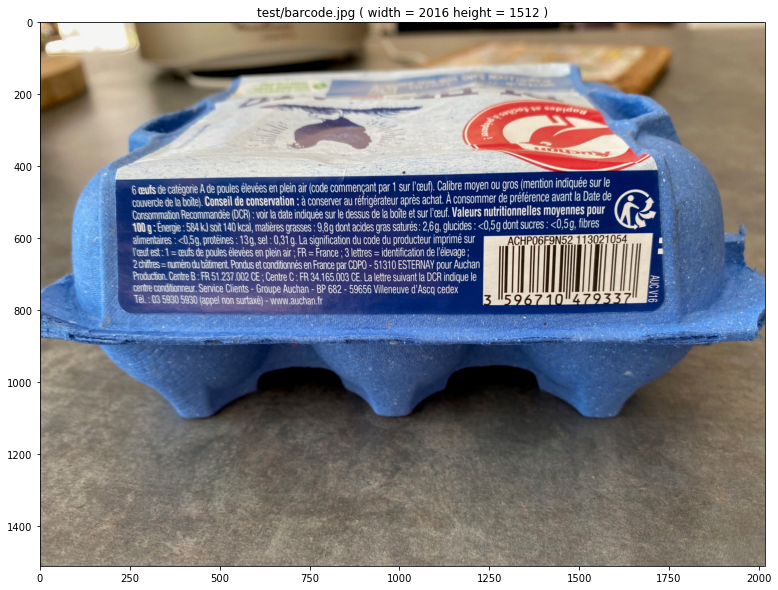

In [9]:
test_file1 = "test/barcode.jpg"
my.image_view(test_file1)

In [12]:
results = decode(cv2.imread(test_file1))
print(results)

for idx in results:
    barcodetext = idx.data.decode("utf-8")
    print("\nBarcode Text =", barcodetext)

[Decoded(data=b'3596710479337', type='EAN13', rect=Rect(left=1275, top=624, width=395, height=122), polygon=[Point(x=1275, y=733), Point(x=1275, y=745), Point(x=1475, y=746), Point(x=1660, y=746), Point(x=1661, y=740), Point(x=1670, y=632), Point(x=1670, y=624), Point(x=1278, y=625), Point(x=1277, y=633), Point(x=1276, y=679)], quality=177, orientation=None)]

Barcode Text = 3596710479337


True

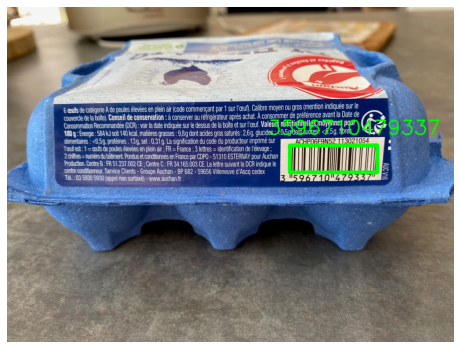

In [13]:
img = cv2.cvtColor(cv2.imread(test_file1), cv2.COLOR_BGR2RGB)
x1 = results[0][2][0]
y1 = results[0][2][1]
x2 = x1 + results[0][2][2]
y2 = y1 + results[0][2][3]

cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 15)
cv2.putText(img, barcodetext, (x1 - 100, y1 - 50), cv2.FONT_HERSHEY_SIMPLEX, 3,
            (0, 255, 0), 5)
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis("off")
cv2.imwrite(RESULTS_DIR + "/barcode_result1.jpg",
            cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## 3. Processing all the catalog images for Bar Code text extraction

In [14]:
maxworkers = 40
print("We will run in // the process usig the", maxworkers,
      "(number of workers thread)")
print("Default value is =", os.cpu_count() * 5)

We will run in // the process usig the 40 (number of workers thread)
Default value is = 40


In [15]:
start = my.now()
dfbarcode = pd.DataFrame()
idx = 0
idx2 = 0
barcodes_list = []

print("Running the Barcode/QRcode text extraction on the", len(files),
      "images...\n")

# Launching a parralel task for the Bar Code
with concurrent.futures.ThreadPoolExecutor(max_workers=maxworkers) as executor:
    results = executor.map(my.get_barcode_text, files)

    for barcode_text in results:
        if idx % 50 == 1:
            idx2 = idx - 1
            nb_todo = len(files) - idx2
            pct_done = round((idx2 / len(files)) * 100)
            print(my.get_today(), "Number of processed files:", f"{idx2:9}",
                  "| Remaining files:", f"{nb_todo:9}", "| Done:", pct_done,
                  "%")

        barcodes_list.append(barcode_text)
        dfbarcode = pd.concat([
            pd.DataFrame(files, columns=['imagefile']),
            pd.DataFrame(barcodes_list, columns=['barcodetext'])
        ],
                              axis=1)

        idx += 1

del barcodes_list[:]

print("\nEnd of job. Number of processed files =", idx)
print("\nDone in", (my.now() - start).in_words(locale='en'))
print("Average time per image =",
      ((my.now() - start) / len(files)).in_words(locale='en'))

Running the Barcode/QRcode text extraction on the 466 images...

18-10-2022 14:07:18 Number of processed files:         0 | Remaining files:       466 | Done: 0 %
18-10-2022 14:07:19 Number of processed files:        50 | Remaining files:       416 | Done: 11 %
18-10-2022 14:07:20 Number of processed files:       100 | Remaining files:       366 | Done: 21 %
18-10-2022 14:07:20 Number of processed files:       150 | Remaining files:       316 | Done: 32 %
18-10-2022 14:07:21 Number of processed files:       200 | Remaining files:       266 | Done: 43 %
18-10-2022 14:07:21 Number of processed files:       250 | Remaining files:       216 | Done: 54 %
18-10-2022 14:07:22 Number of processed files:       300 | Remaining files:       166 | Done: 64 %
18-10-2022 14:07:22 Number of processed files:       350 | Remaining files:       116 | Done: 75 %
18-10-2022 14:07:23 Number of processed files:       400 | Remaining files:        66 | Done: 86 %
18-10-2022 14:07:23 Number of processed files

## 4. Results

In [16]:
RESULTS_FOLDER = "results"

In [17]:
my.create_dir(RESULTS_FOLDER)

Dir results exist. So you can use it


In [14]:
dfbarcode.shape

(466, 2)

In [18]:
dfbarcode

imagefile barcodetext
0    ./images/catalog_images/catalog_image_00001.jpg            
1    ./images/catalog_images/catalog_image_00002.jpg            
2    ./images/catalog_images/catalog_image_00003.jpg            
3    ./images/catalog_images/catalog_image_00004.jpg            
4    ./images/catalog_images/catalog_image_00005.jpg            
..                                               ...         ...
461  ./images/catalog_images/catalog_image_00462.jpg            
462  ./images/catalog_images/catalog_image_00463.jpg            
463  ./images/catalog_images/catalog_image_00464.jpg            
464  ./images/catalog_images/catalog_image_00465.jpg            
465  ./images/catalog_images/catalog_image_00466.jpg            

[466 rows x 2 columns]

In [19]:
nobarcode = (dfbarcode['barcodetext'] == '').sum()

print("Number of empty Bar Code text =", nobarcode)
print("Number of empty Bar Code text in % =",
      round(nobarcode / dfbarcode.shape[0] * 100, 2))
print("Number of Bar Code text =", dfbarcode.shape[0] - nobarcode)
print("Number of Bar Code text in % =",
      round((dfbarcode.shape[0] - nobarcode) / dfbarcode.shape[0] * 100, 2))

categories = ['BarCode', 'No BarCode']
catval = [dfbarcode.shape[0] - nobarcode, nobarcode]
colors = ['green', 'red']

fig = go.Figure(
    data=[go.Pie(labels=categories, values=catval, textinfo='label+percent')])
fig.update_traces(textfont_size=12, marker=dict(colors=colors))
fig.show()
fig.write_image(RESULTS_FOLDER + "/barcode_catalog_results.png")

Number of empty Bar Code text = 391
Number of empty Bar Code text in % = 83.91
Number of Bar Code text = 75
Number of Bar Code text in % = 16.09


In [20]:
dfbarcode[dfbarcode['barcodetext'] != '']

imagefile    barcodetext
12   ./images/catalog_images/catalog_image_00013.jpg  3278692111145
41   ./images/catalog_images/catalog_image_00042.jpg       50129386
45   ./images/catalog_images/catalog_image_00046.jpg  3329770062740
50   ./images/catalog_images/catalog_image_00051.jpg  8413080001119
51   ./images/catalog_images/catalog_image_00052.jpg  8413080001119
..                                               ...            ...
447  ./images/catalog_images/catalog_image_00448.jpg  4061462132087
451  ./images/catalog_images/catalog_image_00452.jpg  4061458132053
452  ./images/catalog_images/catalog_image_00453.jpg  4061458132053
454  ./images/catalog_images/catalog_image_00455.jpg  4316734032047
457  ./images/catalog_images/catalog_image_00458.jpg  4061462132100

[75 rows x 2 columns]

### 5. Saving results

In [21]:
outfilename_barcode = RESULTS_FOLDER + "/barcode_catalog_results"
start = my.now()

print("Exporting results to a pkl file...")
dfbarcode.to_pickle(outfilename_barcode + '.pkl')

print("\nDone in", (my.now() - start).in_words(locale='en'))

Exporting results to a pkl file...

Done in 0.11 second


In [22]:
my.list_dir(RESULTS_FOLDER)

Files in directory: results 

1 	 2022-10-18 14:07:59.092613 27.1 kB 	 barcode_catalog_results.pkl
2 	 2022-10-18 14:07:49.367091 23.7 kB 	 barcode_catalog_results.png
3 	 2022-10-18 14:07:10.074222 1.1 MB 	 barcode_result1.jpg
4 	 2022-10-18 14:02:03.820259 1.2 MB 	 vectext_catalog_results.pkl
5 	 2022-10-18 14:01:57.121064 23.4 kB 	 vectext_catalog_results.png


In [23]:
# Saving to Azure ML workspace
workspace = Workspace(subscription_id, resource_group, workspace_name)
datastore = workspace.get_default_datastore()
ds = Dataset.File.upload_directory(src_dir=RESULTS_FOLDER,
                                   target=DataPath(datastore,RESULTS_FOLDER),
                                   show_progress=True,
                                   overwrite=True)

Validating arguments.
Arguments validated.
Uploading file to results
Uploading an estimated of 5 files
Uploading results/barcode_catalog_results.png
Uploaded results/barcode_catalog_results.png, 1 files out of an estimated total of 5
Uploading results/barcode_catalog_results.pkl
Uploaded results/barcode_catalog_results.pkl, 2 files out of an estimated total of 5
Uploading results/barcode_result1.jpg
Uploaded results/barcode_result1.jpg, 3 files out of an estimated total of 5
Uploading results/vectext_catalog_results.pkl
Uploaded results/vectext_catalog_results.pkl, 4 files out of an estimated total of 5
Uploading results/vectext_catalog_results.png
Uploaded results/vectext_catalog_results.png, 5 files out of an estimated total of 5
Uploaded 5 files
Creating new dataset


## 5. Testing saved pkl file

In [24]:
barcodepkl = RESULTS_FOLDER + "/barcode_catalog_results"

In [25]:
df = pd.read_pickle(barcodepkl + '.pkl')
df

imagefile barcodetext
0    ./images/catalog_images/catalog_image_00001.jpg            
1    ./images/catalog_images/catalog_image_00002.jpg            
2    ./images/catalog_images/catalog_image_00003.jpg            
3    ./images/catalog_images/catalog_image_00004.jpg            
4    ./images/catalog_images/catalog_image_00005.jpg            
..                                               ...         ...
461  ./images/catalog_images/catalog_image_00462.jpg            
462  ./images/catalog_images/catalog_image_00463.jpg            
463  ./images/catalog_images/catalog_image_00464.jpg            
464  ./images/catalog_images/catalog_image_00465.jpg            
465  ./images/catalog_images/catalog_image_00466.jpg            

[466 rows x 2 columns]

In [26]:
barcode_df = df[df['barcodetext'] != '']
barcode_df

imagefile    barcodetext
12   ./images/catalog_images/catalog_image_00013.jpg  3278692111145
41   ./images/catalog_images/catalog_image_00042.jpg       50129386
45   ./images/catalog_images/catalog_image_00046.jpg  3329770062740
50   ./images/catalog_images/catalog_image_00051.jpg  8413080001119
51   ./images/catalog_images/catalog_image_00052.jpg  8413080001119
..                                               ...            ...
447  ./images/catalog_images/catalog_image_00448.jpg  4061462132087
451  ./images/catalog_images/catalog_image_00452.jpg  4061458132053
452  ./images/catalog_images/catalog_image_00453.jpg  4061458132053
454  ./images/catalog_images/catalog_image_00455.jpg  4316734032047
457  ./images/catalog_images/catalog_image_00458.jpg  4061462132100

[75 rows x 2 columns]

In [27]:
barcode_df['barcodetext'][12]

'3278692111145'

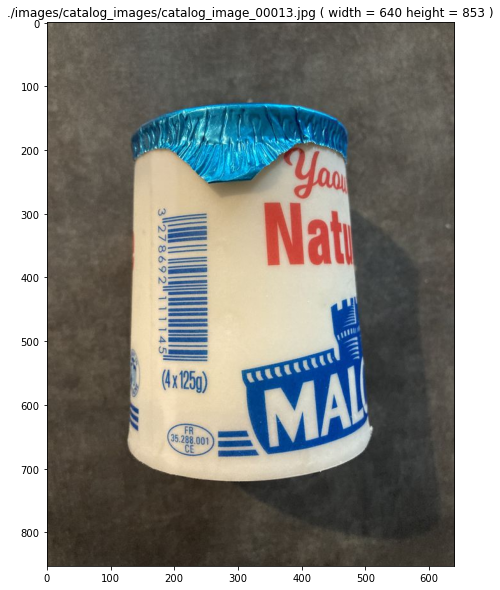

In [28]:
my.image_view(barcode_df['imagefile'][12])

> End of notebook